[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/recommendation/movie-recommender/xx_train_movie_recommender.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/recommendation/movie-recommender/xx_train_movie_recommender.ipynb)

In [ ]:
!nvidia-smi

In [2]:
!pip install datasets tensorflow huggingface-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 4.7 MB/s 
     |████████████████████████████████| 101 kB 13.1 MB/s 
     |████████████████████████████████| 212 kB 55.8 MB/s 
     |████████████████████████████████| 115 kB 61.2 MB/s 
     |████████████████████████████████| 127 kB 62.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Load and Prepare Dataset

In [1]:
from datasets import load_dataset

movies = load_dataset('pinecone/movielens-recent-ratings')
train = movies['train'].to_pandas()
test = movies['test'].to_pandas()

del movies

  0%|          | 0/2 [00:00<?, ?it/s]

# Training the Model

In [2]:
# ROW_COUNT = train.shape[0]
EMBEDDING_SIZE = 32
NUM_USERS = train['user_id'].nunique()
NUM_MOVIES = train['movie_id'].nunique()

In [3]:
NUM_MOVIES, NUM_USERS

(10269, 35710)

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

### User Model

In [5]:
u_inputs = layers.Input(shape=(1,), name='user_id')
user_emb = layers.Embedding(output_dim=32, input_dim=NUM_USERS, name='user_emb')(u_inputs)
user_model = keras.Model(u_inputs, user_emb)
user_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_id (InputLayer)        [(None, 1)]               0         
                                                                 
 user_emb (Embedding)        (None, 1, 32)             1142720   
                                                                 
Total params: 1,142,720
Trainable params: 1,142,720
Non-trainable params: 0
_________________________________________________________________


### Movie Model

In [6]:
m_inputs = layers.Input(shape=(1,), name='movie_embedding')
movie_emb = layers.Embedding(output_dim=32, input_dim=NUM_MOVIES, name='movie_emb')(m_inputs)
movie_model = keras.Model(m_inputs, movie_emb)
movie_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 movie_embedding (InputLayer  [(None, 1)]              0         
 )                                                               
                                                                 
 movie_emb (Embedding)       (None, 1, 32)             328608    
                                                                 
Total params: 328,608
Trainable params: 328,608
Non-trainable params: 0
_________________________________________________________________


### Merged Model

We merge the two models via a dot product layer (which is normalized, and so is equivalent to cosine similarity) between the movie embedding and user embedding layers. This allows us to optimize the two models to produce similar movie/user embeddings when the ratings between both are higher.

In [7]:
merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])

In [8]:
adam = keras.optimizers.Adam(lr=0.001)
model = keras.Model([m_inputs, u_inputs], merged)
model.compile(optimizer=adam, loss= 'mean_absolute_error')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie_embedding (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 movie_emb (Embedding)          (None, 1, 32)        328608      ['movie_embedding[0][0]']        
                                                                                                  
 user_emb (Embedding)           (None, 1, 32)        1142720     ['user_id[0][0]']                
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Now we normalize the ratings.

In [9]:
norm_rating_train = train.rating/5
norm_rating_test = test.rating/5

And train...

In [10]:
history = model.fit([train.movie_id, train.user_id], norm_rating_train, batch_size=128,
                              epochs = 10, validation_data = ([test.movie_id, test.user_id], norm_rating_test),
                              verbose = 1)

Epoch 1/10
6825/6825 [==============================] - 31s 4ms/step - loss: 0.2525 - val_loss: 0.1437
Epoch 2/10
6825/6825 [==============================] - 27s 4ms/step - loss: 0.1323 - val_loss: 0.1353
Epoch 3/10
6825/6825 [==============================] - 29s 4ms/step - loss: 0.1197 - val_loss: 0.1311
Epoch 4/10
6825/6825 [==============================] - 28s 4ms/step - loss: 0.1118 - val_loss: 0.1285
Epoch 5/10
6825/6825 [==============================] - 27s 4ms/step - loss: 0.1063 - val_loss: 0.1272
Epoch 6/10
6825/6825 [==============================] - 29s 4ms/step - loss: 0.1024 - val_loss: 0.1266
Epoch 7/10
6825/6825 [==============================] - 27s 4ms/step - loss: 0.0995 - val_loss: 0.1260
Epoch 8/10
6825/6825 [==============================] - 29s 4ms/step - loss: 0.0972 - val_loss: 0.1252
Epoch 9/10
6825/6825 [==============================] - 28s 4ms/step - loss: 0.0953 - val_loss: 0.1249
Epoch 10/10
6825/6825 [==============================] - 27s 4ms/step - l

### Training History

In [11]:
import matplotlib.pyplot as plt

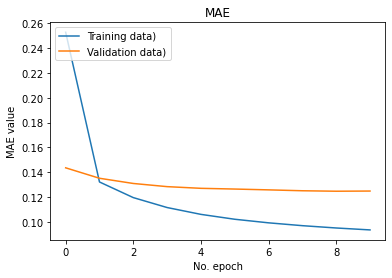

In [12]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training data)')
plt.plot(history.history['val_loss'], label='Validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()